# Exploratory Data Analysis (EDA)
## WiDS Global Datathon – Wildfire Prediction

This notebook explores the structure of the wildfire dataset used to predict
whether and when a wildfire will threaten an evacuation zone. All analysis
focuses on information available within the first five hours after ignition.

In [2]:
import sys
sys.executable


'c:\\Users\\danni\\AppData\\Local\\Programs\\Python\\Python310\\python.exe'

## Data Loading

We begin by loading the training data, test data, and metadata file provided
by the competition.


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
metadata = pd.read_csv("metaData.csv")

train.shape, test.shape


((221, 37), (95, 35))

## Feature Overview

This section inspects the available features in the training dataset,
including fire growth metrics, spatial movement indicators, and temporal
context variables.


In [4]:
train.columns




Index(['event_id', 'num_perimeters_0_5h', 'dt_first_last_0_5h',
       'low_temporal_resolution_0_5h', 'area_first_ha', 'area_growth_abs_0_5h',
       'area_growth_rel_0_5h', 'area_growth_rate_ha_per_h', 'log1p_area_first',
       'log1p_growth', 'log_area_ratio_0_5h', 'relative_growth_0_5h',
       'radial_growth_m', 'radial_growth_rate_m_per_h',
       'centroid_displacement_m', 'centroid_speed_m_per_h',
       'spread_bearing_deg', 'spread_bearing_sin', 'spread_bearing_cos',
       'dist_min_ci_0_5h', 'dist_std_ci_0_5h', 'dist_change_ci_0_5h',
       'dist_slope_ci_0_5h', 'closing_speed_m_per_h',
       'closing_speed_abs_m_per_h', 'projected_advance_m',
       'dist_accel_m_per_h2', 'dist_fit_r2_0_5h', 'alignment_cos',
       'alignment_abs', 'cross_track_component', 'along_track_speed',
       'event_start_hour', 'event_start_dayofweek', 'event_start_month',
       'time_to_hit_hours', 'event'],
      dtype='object')

## Target Variable Investigation

The dataset does not include separate binary labels for each prediction horizon.
Instead, targets are defined using a time-to-event formulation.


In [5]:
[col for col in train.columns if "12" in col or "24" in col or "48" in col or "72" in col]

[]

## Time-to-Event Labels

The variable `event` indicates whether a wildfire ever threatens an evacuation zone.
The variable `time_to_hit_hours` represents the number of hours after ignition at
which that threat occurs. If a fire reaches an evacuation zone within 72 hours, event is 1 and time_to_hit_hours is observed. If a fire does not reach an evacuation zone within 72 hours, event is 0 and time_to_hit_hours is censored at the last available observation. These variables are used to derive binary targets for
multiple prediction horizons.


## Kaplan Meier Curves
We have to use both `event` + `time_to_hit_hours` to predict probability of a fire hitting by a certain time. Since there's two factors to take into consideration for the final predictions, we can't just use a standard correlation coefficient (kaplan, pearson, kendall, etc.) to see how the columns are related. If we only see how different columns are related to `event`, then this ignores the `time_to_hit_hours` column and just gives us info on columns correlated to IF a fire occurs and not WHEN. We also can't just see how columns are related to `time_to_hit_hours` because that doesn't give us info on if a fire occurred or not (because the censoring stops `time_to_hit_hours` at the last available observation). The censored data (when the fire hasn't hit by 72 hours) also means we don't know if a fire hits or not, we just know it hasn't hit by 72 hours. 

Kaplan Meier shows event changing over time but standard correlation is more linear relationships that don't really take time into account. Kaplan Meier is a stepwise function basically that drops every single time an event (fire hitting) occurs. The lower the curve, the more likely a fire hits. It's designed to take in a binary event (occurring or not) as well as time which are the two targets we're given. So we can use Kaplan Meier to plot what's going on with our fire data.

In [6]:
#kaplan meier curve for time to fire
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()

kmf.fit(
    durations=train["time_to_hit_hours"],
    event_observed=train["event"],
    label="All Fires"
)

plt.figure()
kmf.plot_survival_function()
plt.title("Kaplan-Meier Curve for Time to Fire")   
plt.xlabel("Time to Fire (hours)")
plt.ylabel("Survival Probability") #aka probability of not having a fire yet
# higher probability means more likely fire hasn't hit, lower probability means more likely fire has hit
plt.show()

ModuleNotFoundError: No module named 'lifelines'

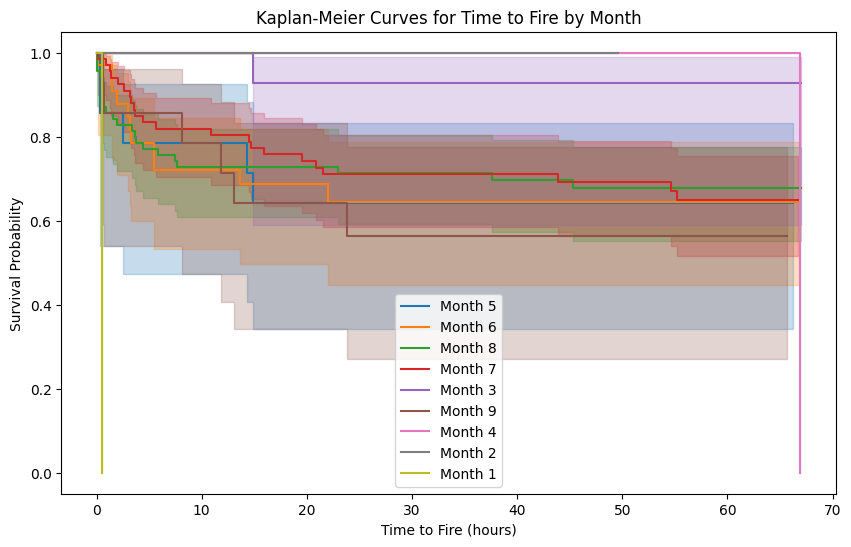

In [ ]:
# stratified kaplan meier curve for time to fire by temporal features
# 1. by month (using event_start_month)
kmf = KaplanMeierFitter()
months = train["event_start_month"].unique()
plt.figure(figsize=(10, 6))
for month in months:
    subset = train[train["event_start_month"] == month] #select rows where event_start_month is equal to the current month
    kmf.fit(
        durations=subset["time_to_hit_hours"],
        event_observed=subset["event"],
        label=f"Month {month}"
    )
    kmf.plot_survival_function()
plt.title("Kaplan-Meier Curves for Time to Fire by Month")
plt.xlabel("Time to Fire (hours)")
plt.ylabel("Survival Probability")
plt.legend()
plt.show()

steep drop: rapid rate of event occurring

shaded bands are confidence intervals - wider = higher uncertainty

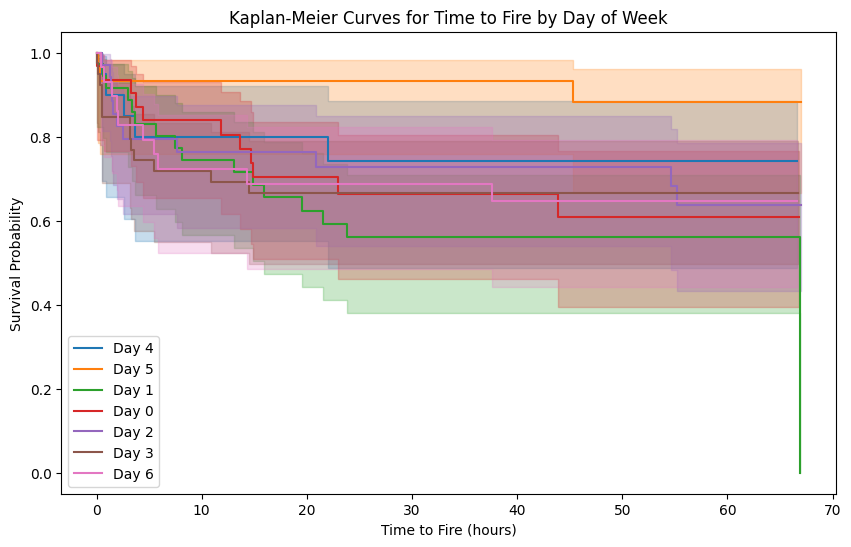

In [ ]:
# 2. by day of week (using event_start_dayofweek)
kmf = KaplanMeierFitter()
days = train["event_start_dayofweek"].unique()
plt.figure(figsize=(10, 6))
for day in days:
    subset = train[train["event_start_dayofweek"] == day]
    kmf.fit(
        durations=subset["time_to_hit_hours"],
        event_observed=subset["event"],
        label=f"Day {day}"
    )
    kmf.plot_survival_function()
plt.title("Kaplan-Meier Curves for Time to Fire by Day of Week")
plt.xlabel("Time to Fire (hours)")
plt.ylabel("Survival Probability")
plt.legend()
plt.show()

a lot of the curves overlap so there's not a strong separation between a fire hitting and what day of the week it started - makes sense

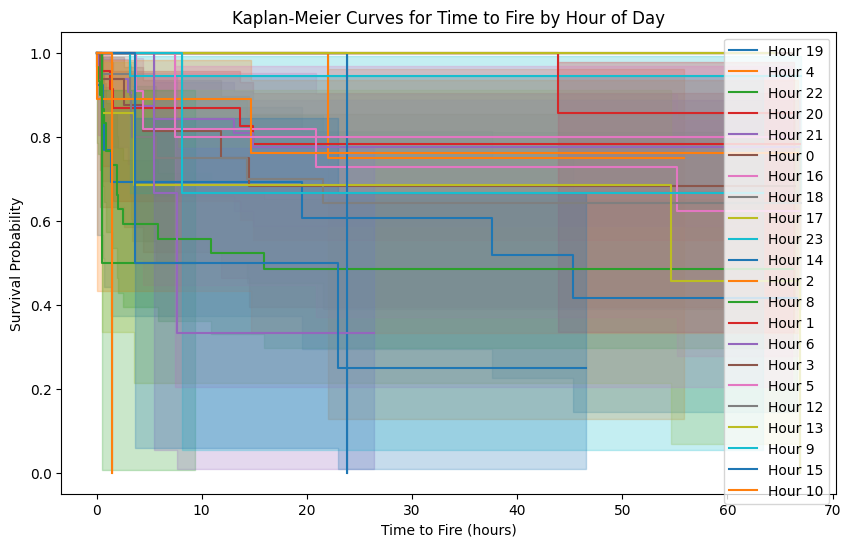

In [ ]:
# 3. by hour of day (using event_start_hour)
kmf = KaplanMeierFitter()
hours = train["event_start_hour"].unique()
plt.figure(figsize=(10, 6))
for hour in hours:
    subset = train[train["event_start_hour"] == hour]
    kmf.fit(
        durations=subset["time_to_hit_hours"],
        event_observed=subset["event"],
        label=f"Hour {hour}"
    )
    kmf.plot_survival_function()
plt.title("Kaplan-Meier Curves for Time to Fire by Hour of Day")
plt.xlabel("Time to Fire (hours)")
plt.ylabel("Survival Probability")
plt.legend(loc ="upper right")
plt.show()

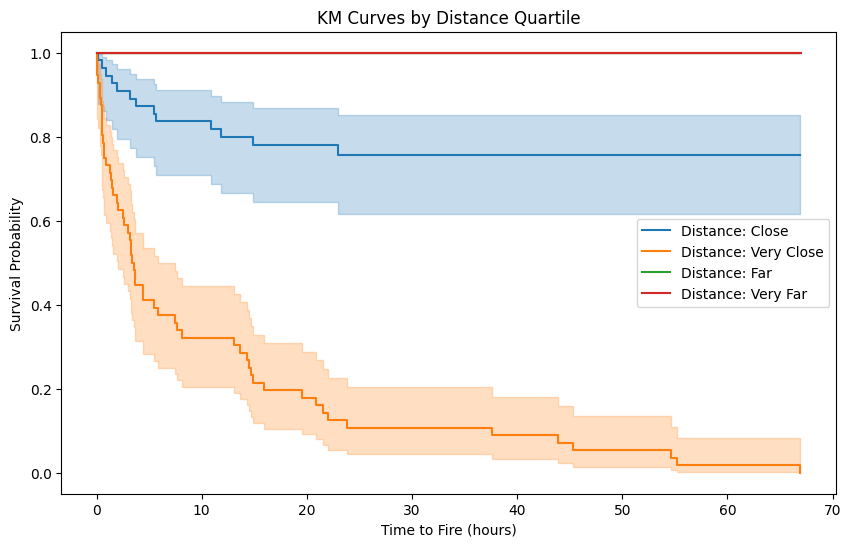

In [ ]:
# stratified by minimum distance to nearest evac zone centroid (meters) (using dist_min_ci_0_5h)
kmf = KaplanMeierFitter()

# Don't want to have each unique distance in its own curve because the graph is unreadable, creating 4 distance groups instead
distance_groups = pd.qcut(
    train["dist_min_ci_0_5h"],
    q=4,
    labels=["Very Close", "Close", "Far", "Very Far"]
)

plt.figure(figsize=(10, 6))

for group in distance_groups.unique():
    subset = train[distance_groups == group]
    kmf.fit(
        durations=subset["time_to_hit_hours"],
        event_observed=subset["event"],
        label=f"Distance: {group}"
    )
    kmf.plot_survival_function()

plt.title("KM Curves by Distance Quartile")
plt.xlabel("Time to Fire (hours)")
plt.ylabel("Survival Probability")
plt.legend()
plt.show()

graph behaves as we expect where close and very close fires to evacuation zones have lower survival probability (aka fire hits)

## Missing Data Analysis (EDA)

In [ ]:
missing = train.isna().mean().sort_values(ascending=False)
missing = (missing * 100).round(2)
missing[missing > 0]



Series([], dtype: float64)

In [ ]:
if missing.sum() == 0:
    print("✓ No missing values found in any columns.")
else:
    missing_nonzero = missing[missing > 0].head(15)
    plt.figure(figsize=(10, 5))
    missing_nonzero.sort_values().plot(kind="barh")
    plt.title("Top Missingness (% of rows)")
    plt.xlabel("Missing (%)")
    plt.tight_layout()
    plt.show()


✓ No missing values found in any columns.


### Missing Data Findings

No missing values were detected in the training dataset.  
This suggests the dataset has been pre-cleaned and does not require imputation.

Implication for modeling:
- No need for missing value handling strategies.
- All features are fully populated and usable for model training.


## Duplicate Data Analysis 

In [ ]:
duplicates = train.duplicated().sum()
print(f"Total duplicate rows: {duplicates}")

if 'event_id' in train.columns:
    duplicate_ids = train['event_id'].duplicated().sum()
    print(f"Duplicate event_id values: {duplicate_ids}")


Total duplicate rows: 0
Duplicate event_id values: 0


### Duplicate Data Findings

- Duplicate rows: 0
- Duplicate event_id values: 0

Implication:
Zero duplicates exist, the dataset maintains row-level integrity (Each row represents one unique, valid observation — and nothing is accidentally repeated.).


## Numerical Distribution Analysis 

In [7]:
numerical_cols = train.select_dtypes(include=['int64','float64']).columns
numerical_cols = [col for col in numerical_cols if col not in ['event_id','event','time_to_hit_hours']]

train[numerical_cols].describe().T


,count,mean,std,min,25%,50%,75%,max
num_perimeters_0_5h,221.0,2.063348,2.578859,1.000000e+00,1.000000,1.000000,2.000000,17.000000
dt_first_last_0_5h,221.0,0.979869,1.738052,0.000000e+00,0.000000,0.000000,1.356107,4.994457
low_temporal_resolution_0_5h,221.0,0.728507,0.445739,0.000000e+00,0.000000,1.000000,1.000000,1.000000
area_first_ha,221.0,619.131641,1447.723668,3.752484e-02,25.219058,110.149250,485.092561,11942.392115
area_growth_abs_0_5h,221.0,26.332398,187.437018,-2.156175e-05,0.000000,0.000000,0.000000,2508.041442
area_growth_rel_0_5h,221.0,0.178909,1.302001,-1.437844e-07,0.000000,0.000000,0.000000,17.889695
area_growth_rate_ha_per_h,221.0,6.167128,40.467370,-5.292846e-06,0.000000,0.000000,0.000000,520.443033
log1p_area_first,221.0,4.683276,2.083529,3.683791e-02,3.266487,4.710874,6.186399,9.387933
log1p_growth,221.0,0.389346,1.340348,0.000000e+00,0.000000,0.000000,0.000000,7.827656
log_area_ratio_0_5h,221.0,0.065434,0.300321,-1.437844e-07,0.000000,0.000000,0.000000,2.938617


## Numerical Feature Observations

Most features contain no missing values and complete observations.

Several growth-related variables are highly right-skewed, with medians near zero and large maximum values.

Distance-based features show wide variance, suggesting large variability in fire proximity to evacuation zones.

Many growth features contain zero-heavy distributions, indicating limited early fire spread in a substantial portion of events.

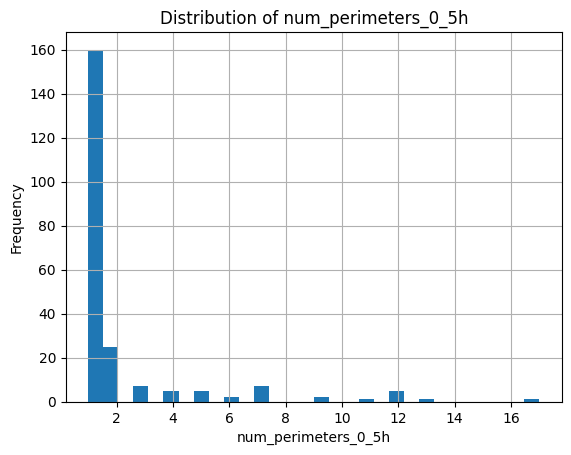

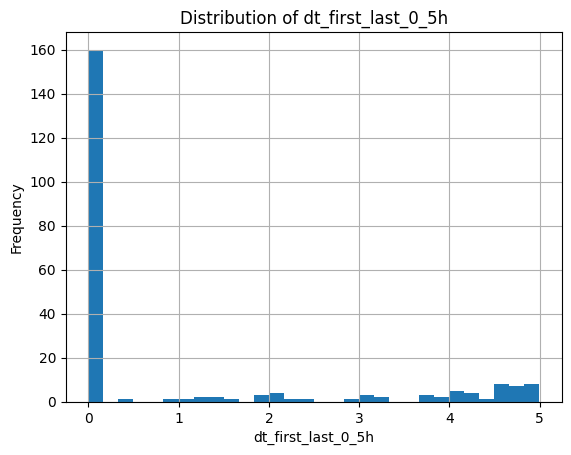

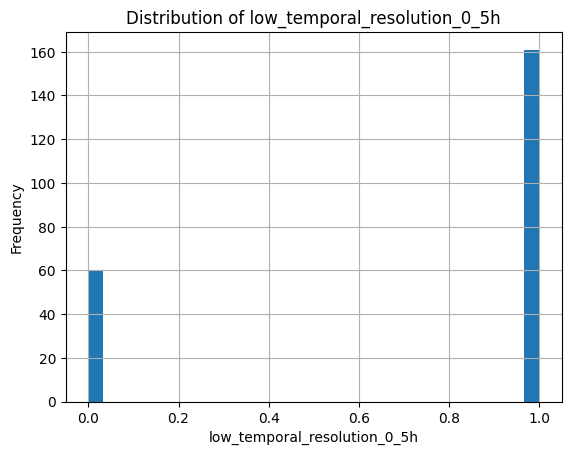

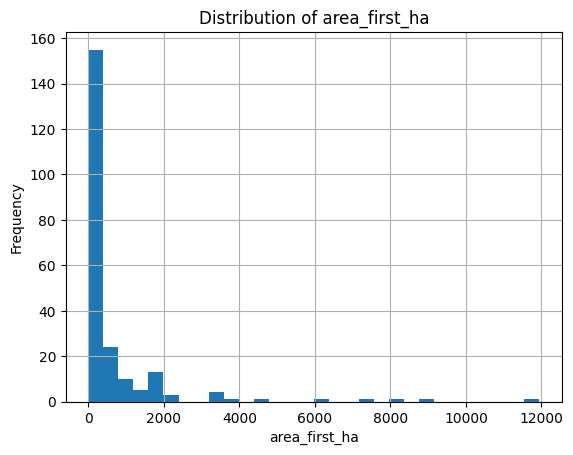

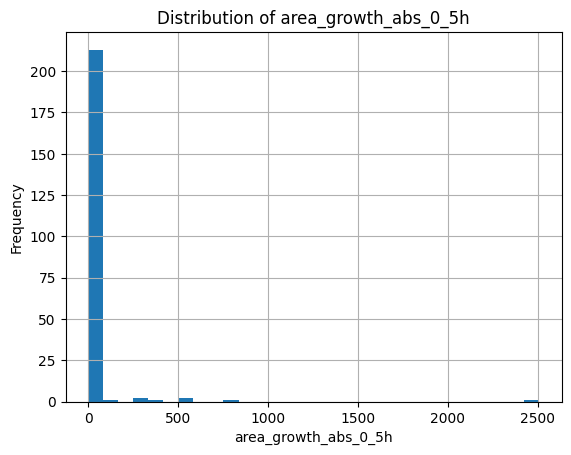

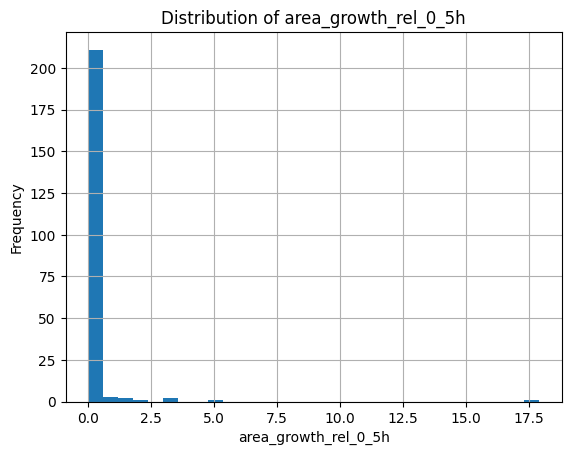

In [8]:
import matplotlib.pyplot as plt

# exclude identifiers and targets
exclude_cols = ['event_id', 'event', 'time_to_hit_hours']
numerical_cols = train.select_dtypes(include=['int64','float64']).columns
numerical_cols = [col for col in numerical_cols if col not in exclude_cols]

# plot first 6 features as example
for col in numerical_cols[:6]:
    plt.figure()
    train[col].hist(bins=30)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()


### num_perimeters_0_5h
Heavy right skew.
Most fires have 1–2 perimeters; a small number have many updates (long tail).

Additional insight:
This may proxy monitoring intensity or fire complexity. Fires with more perimeter updates in the first 5 hours could indicate higher activity, operational attention, or irregular spread.

Modeling considerations:
Count-like and skewed distribution.
Log transformation may benefit linear or survival regression models.
Likely interacts with growth-related features.
May indirectly signal early instability, which could influence hazard rates.

### dt_first_last_0_5h
Large spike at 0, then spread up to 5 hours.

Interpretation:
A value of 0 likely indicates only one recorded perimeter in the first 5 hours (no measurable time gap). Non-zero values indicate multiple observations and temporal evolution.

Modeling considerations:
Semi-zero-inflated behavior.
Binary transformation (dt_first_last_0_5h > 0) may capture meaningful structure.
Represents temporal richness of early fire observation.
Could impact reliability of growth metrics and hazard estimation.
low_temporal_resolution_0_5h
Binary feature, mostly 1.

Interpretation:
Indicates reduced temporal resolution in the first 5 hours. Majority class suggests many fires lack high-frequency monitoring.

Modeling considerations:
Treat strictly as binary.
Class imbalance present.
May affect precision of early growth signals.
Consider interaction terms with area and spread metrics.

### Growth & Area Features
(area_first_ha, area_growth_abs_0_5h, area_growth_rel_0_5h)

All show strong right skew with extreme outliers.

Interpretation:
Most fires remain small in early hours, but a small subset exhibit aggressive expansion. This aligns with real wildfire dynamics, where rapid early growth is uncommon but critical.

Modeling considerations:
Log transformation (e.g., log1p) may stabilize variance.
Extreme values could disproportionately influence linear survival models.
Likely strong predictors of time-to-threat and hazard intensity.

### Early Behavior Summary

The first 5-hour features show strong skewness, sparse extreme growth events, and variable temporal monitoring resolution. 
These characteristics suggest that early fire behavior is highly heterogeneous. 
Feature transformations and careful modeling choices will be important to capture rare but high-risk growth patterns without being dominated by outliers.


### Target-Conditioned Feature Comparison
(Do high growth features correspond to shorter time_to_hit?)

Objective:
Evaluate whether early growth features differ between fires that eventually hit (event = 1) and those that do not (event = 0).




In [9]:
train.groupby('event')[['area_growth_abs_0_5h',
                         'area_growth_rel_0_5h',
                         'num_perimeters_0_5h']].mean()


,area_growth_abs_0_5h,area_growth_rel_0_5h,num_perimeters_0_5h
event,,,
0,6.383025,0.033640,1.421053
1,70.278843,0.498922,3.478261


Observed Differences:
Fires that eventually hit (event = 1) show:
    ~11× higher absolute growth in first 5 hours
    (70.3 vs 6.38 ha)

    ~15× higher relative growth
    (0.50 vs 0.03)

    More perimeter updates recorded
    (3.48 vs 1.42)

Interpretation
This suggests that:
    Early fire expansion is strongly associated with eventual hit.
    Rapid growth within the first 5 hours is likely a key early risk indicator.
    Increased perimeter counts may reflect either:
        Greater fire complexity
        More active monitoring of unstable fires

These features appear to contain strong predictive signal.

Modeling Implications
    Growth-related variables are likely high-importance predictors.
    These variables may significantly influence hazard in survival modeling.
    Interaction effects between growth and monitoring intensity should be explored.

### Relationship Between Early Growth and Time to Hit
(Does higher growth correspond to shorter time_to_hit?)

In [10]:
# Only look at rows where the event actually happened
hits = train[train["event"] == 1].copy()

# Quick sanity: do higher growth fires hit sooner?
hits[["time_to_hit_hours", "area_growth_abs_0_5h", "area_growth_rel_0_5h", "num_perimeters_0_5h"]].corr()["time_to_hit_hours"].sort_values()


num_perimeters_0_5h    -0.356114
area_growth_abs_0_5h   -0.130992
area_growth_rel_0_5h   -0.119650
time_to_hit_hours       1.000000
Name: time_to_hit_hours, dtype: float64

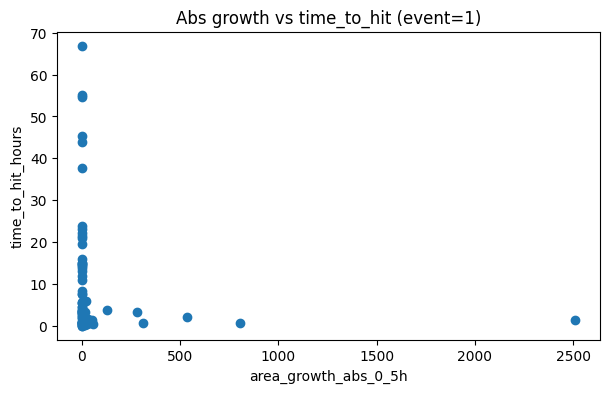

In [11]:
import matplotlib.pyplot as plt

# Scatter: abs growth vs time to hit (event=1 only)
plt.figure(figsize=(7,4))
plt.scatter(hits["area_growth_abs_0_5h"], hits["time_to_hit_hours"])
plt.xlabel("area_growth_abs_0_5h")
plt.ylabel("time_to_hit_hours")
plt.title("Abs growth vs time_to_hit (event=1)")
plt.show()


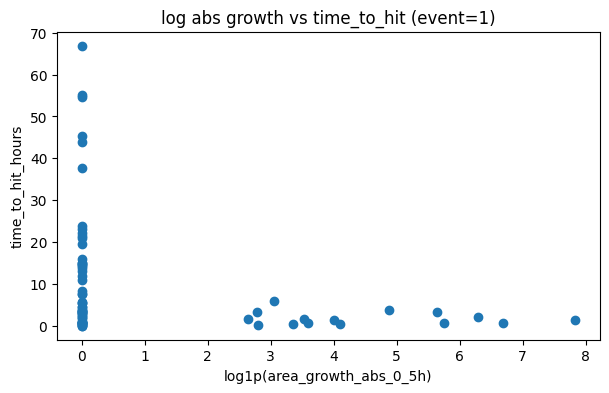

In [12]:
# Same but log-scaled x (helps with heavy skew)
plt.figure(figsize=(7,4))
plt.scatter((hits["area_growth_abs_0_5h"] + 1).apply(lambda x: __import__("math").log(x)), hits["time_to_hit_hours"])
plt.xlabel("log1p(area_growth_abs_0_5h)")
plt.ylabel("time_to_hit_hours")
plt.title("log abs growth vs time_to_hit (event=1)")
plt.show()


Correlation analysis (event=1 only) shows:
    num_perimeters_0_5h has a moderate negative correlation (-0.36) with time_to_hit_hours.
    Growth features (area_growth_abs_0_5h, area_growth_rel_0_5h) show weak negative correlations (~ -0.12 to -0.13).

Interpretation:
    Fires with more early perimeter updates tend to hit the event sooner.
    Faster early growth is associated with slightly shorter time-to-hit.
    Monitoring intensity (num_perimeters) appears more predictive than raw growth magnitude.

The scatterplots (especially log-scaled growth) suggest:
    Most fires cluster near low growth.
    High-growth fires generally hit quickly (low time_to_hit).
    Some low-growth fires still hit late (vertical spread near x ≈ 0).

Implication:
Early fire dynamics contain predictive signal for time-to-event modeling.